In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter

In [3]:
def text_to_seq(text_sample):
    char_counts = Counter(text_sample)
    char_counts = sorted(char_counts.items(), key = lambda x: x[1], reverse=True)

    sorted_chars = [char for char, _ in char_counts]
    char_to_idx = {char: index for index, char in enumerate(sorted_chars)}
    idx_to_char = {v: k for k, v in char_to_idx.items()}

    sequence = np.array([char_to_idx[char] for char in text_sample])

    return sequence, char_to_idx, idx_to_char

In [4]:
def get_batch(sequence):
    trains = []
    targets = []

    for _ in range(BATCH_SIZE):
        batch_start = np.random.randint(0, len(sequence) - SEQ_LEN)
        chunk = sequence[batch_start: batch_start + SEQ_LEN]
        train = torch.LongTensor(chunk[:-1]).view(-1, 1)
        target = torch.LongTensor(chunk[1:]).view(-1, 1)
        trains.append(train)
        targets.append(target)

    return torch.stack(trains, dim=0), torch.stack(targets, dim=0)

In [5]:
def evaluate(model, char_to_idx, idx_to_char, start_text=' ', prediction_len=200, temp=0.3):
    hidden = model.init_hidden()
    idx_input = [char_to_idx[char] for char in start_text]
    train = torch.LongTensor(idx_input).view(-1, 1, 1).to(device)
    predicted_text = start_text

    _, hidden = model(train, hidden)

    inp = train[-1].view(-1, 1, 1)

    for i in range(prediction_len):
        output, hidden = model(inp.to(device), hidden)
        output_logits = output.cpu().data.view(-1)
        p_next = F.softmax(output_logits / temp, dim=-1).detach().cpu().data.numpy()
        top_index = np.random.choice(len(char_to_idx), p=p_next)
        inp = torch.LongTensor([top_index]).view(-1, 1, 1).to(device)
        predicted_char = idx_to_char[top_index]
        predicted_text += predicted_char

    return predicted_text

In [6]:
SEQ_LEN = 256
BATCH_SIZE = 16

# Load the text data
TRAIN_TEXT_FILE_PATH = './dataRNN.txt'


In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size, n_layers=1):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(self.input_size, self.embedding_size)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.hidden_size, self.input_size)

    def forward(self, x, hidden):
        x = self.encoder(x).squeeze(2)
        out, (ht1, ct1) = self.lstm(x, hidden)
        out = self.dropout(out)
        x = self.fc(out)

        return x, (ht1, ct1)

    def init_hidden(self, batch_size=1):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device),
                torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device))

# Load the text data
with open(TRAIN_TEXT_FILE_PATH) as text_file:
    text_sample = text_file.readlines()

text_sample = ' '.join(text_sample)

# Convert the text data to a sequence of integers
sequence, char_to_idx, idx_to_char = text_to_seq(text_sample)

# Define the device to be used for training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model, criterion, optimizer, and scheduler
model = LSTM(input_size=len(idx_to_char), hidden_size=128, embedding_size=128, n_layers=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=5,
    verbose=True,
    factor=0.5
)

c:\Users\mr.Slave\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [8]:
n_epochs = 1000
loss_avg = []


for epoch in range(n_epochs):
    model.train()
    train, target = get_batch(sequence)
    train = train.permute(1, 0, 2).to(device)
    target = target.permute(1, 0, 2).to(device)
    hidden = model.init_hidden(BATCH_SIZE)

    output, hidden = model(train, hidden)
    loss = criterion(output.permute(1, 2, 0), target.squeeze(-1).permute(1, 0))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_avg.append(loss.item())
    if len(loss_avg) >= 50:
        mean_loss = np.mean(loss_avg)
        print(f'Loss: {mean_loss}')
        scheduler.step(mean_loss)
        loss_avg = []
        model.eval()
        predicted_text = evaluate(model, char_to_idx, idx_to_char)
        print(predicted_text)

Loss: 1.681767926812172
 оценить влияние образования в формирование личности. Влияние образования в современном обществе, предметом особого в формировании личности. Анализ учебных факторов на формирование личности. Анализ уче
Loss: 0.12752174332737923
 образования на развитие критического мышления, этических ценностей и социальной адаптации.Исследование социокультурных факторов, оказывающих влияние на формирование личности. Методы исследования включ
Loss: 0.050547034665942195
 в формировании личности. Анализ учебных программ, методов преподавания и воспитательного процесса позволяет оценить влияние образования на развитие критического мышления, этических ценностей и социаль
Loss: 0.04027858655899763
 в социокультурной сфере, включая влияние масс-медиа, интернета, образования, религии и экономических факторов на формирование личности. Методы исследования включают анализ статистических данных, социо
Loss: 0.03396828170865774
 и экономических факторов на формирование личности. Методы иссл

In [9]:
print(evaluate(model, char_to_idx, idx_to_char))

 образования на развитие критического мышления, этических ценностей и социальной адаптации.Исследование социокультурных факторов, оказывающих влияние на формирование личности в современном обществе, пр


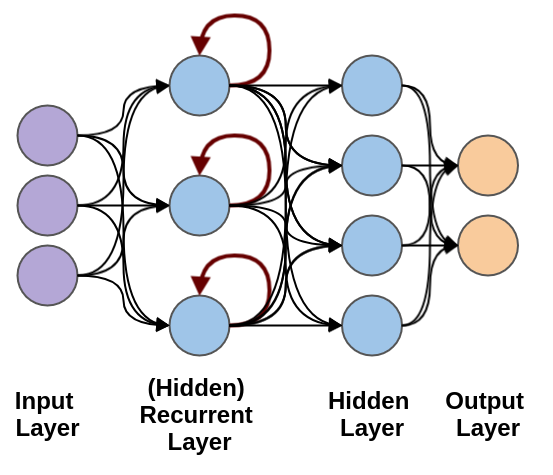

Архитектура LSTM-модели состоит из следующих компонентов:

Слой вложения: Этот слой преобразует входные целочисленные последовательности в плотные векторы с помощью матрицы вложения. Размер встраивания равен 128.

Слой LSTM: Этот слой является ядром модели RNN (рекурентная нейронная сеть). Он обрабатывает входные последовательности и учится отслеживать соответствующую информацию с течением времени. Слой LSTM имеет 128 скрытых блоков и 2 слоя.

Слой отсева: Этот слой используется для предотвращения переобучения путем случайной установки доли входных единиц на ноль во время обучения. Коэффициент отсева установлен на 0,2.

Полносвязный слой (FC): Этот слой используется для вывода прогнозируемых вероятностей для каждого возможного символа в словаре. Слой FC содержит 128 входных единиц и 95 выходных единиц (соответствующих 95 уникальным символам в наборе данных).

Инициализация скрытого состояния: Слою LSTM требуется начальное скрытое состояние, чтобы начать обработку входных последовательностей. Метод инициализирует скрытое состояние нулями.init_hidden

Модель LSTM используется для обучения на текстовом наборе данных, загруженном из файла. С помощью функции текстовые данные преобразуются в целочисленные последовательности. Модель обучается с помощью оптимизатора Адама и функции кросс-энтропийных потерь. Скорость обучения снижается с помощью планировщика ReduceLROnPlateau, если потери валидации не улучшаются в течение 5 эпох.dataRNN.txt и функции text_to_seq

После обучения модель можно использовать для генерации текста с помощью функции. В качестве входных данных функция принимает обученную модель, словари «символ-индекс» и «индекс-символ», а также начальный текст. Он генерирует прогнозируемый текст путем выборки из прогнозируемых вероятностей на каждом временном шаге. Функция evaluate

Вот основные особенности работы рекуррентной нейронной сети:

1. Рекуррентные связи: Основное отличие RNN от других типов нейронных сетей - это наличие рекуррентных связей, которые позволяют информации циркулировать по сети. Это позволяет модели учитывать контекст и зависимости между последовательными элементами входных данных.

2. Внутреннее состояние: RNN обладает внутренним состоянием (hidden state), которое обновляется при каждом новом входе. Это состояние содержит информацию о предыдущих элементах последовательности и используется для обработки следующих элементов.

3. Обработка последовательностей переменной длины: RNN способны обрабатывать последовательности переменной длины, что делает их идеальным инструментом для задач, где входные данные не имеют фиксированного размера.

4. Виды задач: RNN широко используются для задач, таких как машинный перевод, анализ тональности текста, генерация текста, распознавание речи, временные ряды и другие задачи, где важна последовательная природа входных данных.

5. Проблема затухающих и взрывающихся градиентов: Одной из основных проблем RNN является проблема затухающих и взрывающихся градиентов, которая может привести к потере информации в длинных последовательностях. Для решения этой проблемы были разработаны модификации RNN, такие как LSTM (Long Short-Term Memory) и GRU (Gated Recurrent Unit), которые помогают сохранять информацию на протяжении длинных последовательностей.

6. Обучение: RNN обучаются с использованием методов оптимизации, таких как обратное распространение ошибки через время (Backpropagation Through Time), который позволяет настраивать параметры сети на основе последовательных входных данных.